### DAG with latent variables, using d-sep

In [1]:
import os
import sys

os.chdir(r'd:\Git_project\Local_Causal_Discovery')
# 添加项目根目录到 sys.path
project_root = os.path.abspath(os.path.join(os.getcwd()))
print(f"Project root directory: {project_root}")
sys.path.append(project_root)

from Methods.MB_discovery import grow_shrink_mb, TC_mb
import pandas as pd
import numpy as np
import random
from Models.Continuous_model import simulate_dag, Continuous_Model
"""
Example 1: DAG with latent variables, using d-sep
"""
# Parameters
num_nodes = 50
num_edges = 120
alpha = 0.05
method_type = 'D_sep'


identical_num = 0
for i in range(1,101):

    # Simulate a DAG
    DAG = simulate_dag(num_nodes, num_edges, 'ER')
    DAG = pd.DataFrame(DAG, index=[f'V{i+1}' for i in range(num_nodes)], columns=[f'V{i+1}' for i in range(num_nodes)])

    # Determine latent variables
    candidate_latent = [node for node in DAG.columns if DAG.loc[:, node].sum() >= 2]
    latent_num = int(len(candidate_latent) * 0.4)
    latent_variables = random.sample(candidate_latent, latent_num)
    # print(f"Candidate Latent Variables: {candidate_latent}")
    # print(f"Number of Latent Variables: {latent_num}, Latent Variables: {latent_variables}")

    # Randomly select a target variable excluding latent variables
    candidates = list(set(DAG.columns) - set(latent_variables))
    if not candidates:
        raise ValueError("No valid target variables available after excluding latent variables.")
    target = random.choice(candidates)
    # print(f"Target Variable: {target}")

    # Run the algorithms
    mb_gs, ntest_gs = grow_shrink_mb(DAG, target, alpha, method_type, latent_variables=latent_variables)
    mb_tc, ntest_tc = TC_mb(DAG, target, alpha, method_type, latent_variables=latent_variables)

    # Output results
    # print(f"Markov Blanket (Grow-Shrink Algorithm): {mb_gs}")
    # print(f"Number of Conditional Independence Tests (Grow-Shrink): {ntest_gs}")
    # print(f"Markov Blanket (Total Conditioning Algorithm): {mb_tc}")
    # print(f"Number of Conditional Independence Tests (Total Conditioning): {ntest_tc}")

    # Compare results
    if set(mb_gs) == set(mb_tc):
        # print("The Markov Blankets obtained from the Grow-Shrink and Total Conditioning algorithms are identical.")
        identical_num += 1
    else:
        # print("The Markov Blankets obtained from the Grow-Shrink and Total Conditioning algorithms differ.")
        # save the reordered adjacency matrix to a CSV file
        save_path = os.path.join(r'Graph\data_bif', f'random_graph_{i}.csv')
        DAG.to_csv(save_path, index=True, header=True) # index=True indicates to save the index(line names), header=True indicates to save the column names

print(f"Identical Markov Blankets: {identical_num}")

Project root directory: d:\Git_project\Local_Causal_Discovery


KeyboardInterrupt: 

### Evaluate the results of the test.

In [5]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Example usage
true_list = ['V10', 'V20', 'V32', 'V37', 'V42']
learned_list = ['V10', 'V20', 'V32', 'V6', 'V7']

precision = precision_score([1 if node in true_list else 0 for node in DAG.columns],
                            [1 if node in learned_list else 0 for node in DAG.columns])
recall = recall_score([1 if node in true_list else 0 for node in DAG.columns],
                      [1 if node in learned_list else 0 for node in DAG.columns])
f1 = f1_score([1 if node in true_list else 0 for node in DAG.columns],
              [1 if node in learned_list else 0 for node in DAG.columns])

print({"F1 Score": f1, "Recall": recall, "Precision": precision})



def evaluate_lists(true_list, learned_list):
    """
    Evaluate the F1 score, Recall, and Precision of a learned list compared to a true list.

    Parameters:
    - true_list (list): The ground truth list.
    - learned_list (list): The learned list to evaluate.

    Returns:
    - dict: A dictionary containing F1 score, Recall, and Precision.
    """
    # Convert lists to sets for comparison
    true_set = set(true_list)
    learned_set = set(learned_list)

    # Calculate true positives, false positives, and false negatives
    true_positives = len(true_set & learned_set)
    false_positives = len(learned_set - true_set)
    false_negatives = len(true_set - learned_set)

    # Precision, Recall, and F1 score
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return {
        "F1": f1,
        "Recall": recall,
        "Precision": precision
    }

# Example usage
true_list = ['V10', 'V20', 'V32', 'V37', 'V42']
learned_list = ['V10', 'V20', 'V32', 'V6', 'V7']
results = evaluate_lists(true_list, learned_list)
print(results)

{'F1 Score': 0.6, 'Recall': 0.6, 'Precision': 0.6}
{'F1': 0.6, 'Recall': 0.6, 'Precision': 0.6}


### Test with Synthetic Continuous Data

In [5]:


# Parameters
num_nodes = 50
num_edges = 120
alpha = 0.05
method_type = 'FisherZ'
simulate_times = 100
sample_list = [500, 1000, 1500,2000]

# Initialize result dataframes for TC_mb and GS_mb
results_tc = pd.DataFrame(columns=['Recall', 'Precision', 'F1', 'ntest'], index=sample_list)
results_gs = pd.DataFrame(columns=['Recall', 'Precision', 'F1', 'ntest'], index=sample_list)

for num_samples in sample_list:
    results_tc_each_size = pd.DataFrame(columns=['Recall', 'Precision', 'F1', 'ntest'], index=range(simulate_times))
    results_gs_each_size = pd.DataFrame(columns=['Recall', 'Precision', 'F1', 'ntest'], index=range(simulate_times))
    for i in range(simulate_times):
        # Simulate a DAG
        DAG = simulate_dag(num_nodes, num_edges, 'ER')
        DAG = pd.DataFrame(DAG, index=[f'V{i+1}' for i in range(num_nodes)], columns=[f'V{i+1}' for i in range(num_nodes)])

        # Determine latent variables
        candidate_latent = [node for node in DAG.columns if DAG.loc[:, node].sum() >= 2]
        latent_num = int(len(candidate_latent) * 0.4)
        latent_variables = random.sample(candidate_latent, latent_num)
        
        # Randomly select a target variable excluding latent variables
        observed_variables = list(set(DAG.columns) - set(latent_variables))
        if not observed_variables:
            raise ValueError("No valid target variables available after excluding latent variables.")
        target = random.choice(observed_variables)

        true_mb_tc, ntest_tc = TC_mb(DAG, target, alpha, method_type = 'D_sep', latent_variables=latent_variables)
        if len(true_mb_tc) == 0:
            # print(f"True Markov Blanket is empty for target {target}. Skipping this iteration.")
            continue

        # Simulate data
        model = Continuous_Model(DAG, function_type='linear', noise_type='gaussian', sample_size=num_samples)
        # model._read_information_DAG()
        data = model.simulate_scm()
        observed_data = data[observed_variables]
        # Run the algorithms
        mb_gs, ntest_gs = grow_shrink_mb(observed_data, target, alpha, method_type)
        mb_tc, ntest_tc = TC_mb(observed_data, target, alpha, method_type)

        #Save results
        re = evaluate_lists(true_mb_tc, mb_tc)
        results_tc_each_size.loc[i, 'Recall'] = re['Recall']
        results_tc_each_size.loc[i, 'Precision'] = re['Precision']
        results_tc_each_size.loc[i, 'F1'] = re['F1']
        results_tc_each_size.loc[i, 'ntest'] = ntest_tc

        re = evaluate_lists(true_mb_tc, mb_gs)
        results_gs_each_size.loc[i, 'Recall'] = re['Recall']
        results_gs_each_size.loc[i, 'Precision'] = re['Precision']
        results_gs_each_size.loc[i, 'F1'] = re['F1']
        results_gs_each_size.loc[i, 'ntest'] = ntest_gs


    #Save results
    results_tc.loc[num_samples, 'Recall'] = results_tc_each_size['Recall'].mean()
    results_tc.loc[num_samples, 'Precision'] = results_tc_each_size['Precision'].mean()
    results_tc.loc[num_samples, 'F1'] = results_tc_each_size['F1'].mean()
    results_tc.loc[num_samples, 'ntest'] = results_tc_each_size['ntest'].mean()

    results_gs.loc[num_samples, 'Recall'] = results_gs_each_size['Recall'].mean()
    results_gs.loc[num_samples, 'Precision'] = results_gs_each_size['Precision'].mean()
    results_gs.loc[num_samples, 'F1'] = results_gs_each_size['F1'].mean()
    results_gs.loc[num_samples, 'ntest'] = results_gs_each_size['ntest'].mean()

print("Results for TC_mb:")
print(results_tc)
print("Results for GS_mb:")
print(results_gs)


Results for TC_mb:
        Recall Precision        F1      ntest
500   0.610741  0.911859  0.692115      37.33
1000  0.694161  0.918439   0.75361  37.353535
1500  0.715642   0.91656   0.76508      37.19
2000  0.751551  0.911213  0.785249      37.39
Results for GS_mb:
        Recall Precision        F1       ntest
500   0.629173  0.915066  0.712141      241.05
1000  0.703403  0.918278  0.760762  254.292929
1500  0.729535  0.944758  0.797935      231.58
2000  0.756594  0.924684  0.800223      241.38


### Plotting Results

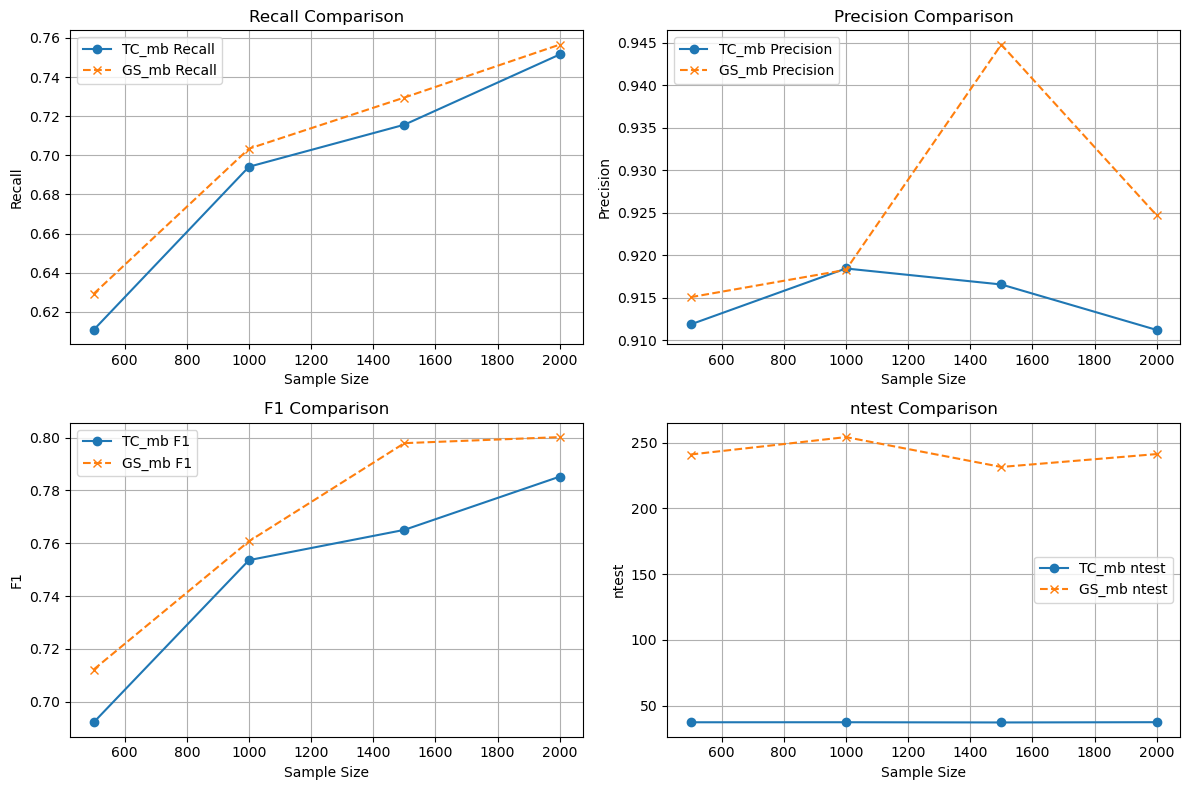

In [6]:
import matplotlib.pyplot as plt

# Extract data for plotting
sample_list = [500, 1000, 1500,2000]
metrics = ['Recall', 'Precision', 'F1', 'ntest']

# Plot each metric for both algorithms
plt.figure(figsize=(12, 8))
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)  # Create a 2x2 grid of subplots
    plt.plot(sample_list, results_tc[metric], marker='o', label=f'TC_mb {metric}')
    plt.plot(sample_list, results_gs[metric], marker='x', linestyle='--', label=f'GS_mb {metric}')
    plt.xlabel('Sample Size')
    plt.ylabel(metric)
    plt.title(f'{metric} Comparison')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


### Test with Synthetic Discrete Data

In [6]:

from Models.Discrete_model import Discrete_Model 
# Parameters
num_nodes = 50
num_edges = 120
alpha = 0.05
method_type = 'G_sq'
simulate_times = 10
sample_list = [500, 1000, 1500, 2000]

# Initialize result dataframes for TC_mb and GS_mb
results_tc = pd.DataFrame(columns=['Recall', 'Precision', 'F1', 'ntest'], index=sample_list)
results_gs = pd.DataFrame(columns=['Recall', 'Precision', 'F1', 'ntest'], index=sample_list)

for num_samples in sample_list:
    results_tc_each_size = pd.DataFrame(columns=['Recall', 'Precision', 'F1', 'ntest'], index=range(simulate_times))
    results_gs_each_size = pd.DataFrame(columns=['Recall', 'Precision', 'F1', 'ntest'], index=range(simulate_times))
    for i in range(simulate_times):
        # Simulate a DAG
        DAG = simulate_dag(num_nodes, num_edges, 'ER')
        DAG = pd.DataFrame(DAG, index=[f'V{i+1}' for i in range(num_nodes)], columns=[f'V{i+1}' for i in range(num_nodes)])

        # Determine latent variables
        candidate_latent = [node for node in DAG.columns if DAG.loc[:, node].sum() >= 2]
        latent_num = int(len(candidate_latent) * 0.4)
        latent_variables = random.sample(candidate_latent, latent_num)
        
        # Randomly select a target variable excluding latent variables
        observed_variables = list(set(DAG.columns) - set(latent_variables))
        if not observed_variables:
            raise ValueError("No valid target variables available after excluding latent variables.")
        target = random.choice(observed_variables)

        true_mb_tc, ntest_tc = TC_mb(DAG, target, alpha, method_type = 'D_sep', latent_variables=latent_variables)
        if len(true_mb_tc) == 0:
            # print(f"True Markov Blanket is empty for target {target}. Skipping this iteration.")
            continue

        # Simulate data
        model = Discrete_Model(DAG, sample_size=num_samples, num_values=2, min_prob=0.0001)
        # model._read_information_DAG()
        data = model.generate_data()
        observed_data = data[observed_variables]
        # Run the algorithms
        mb_gs, ntest_gs = grow_shrink_mb(observed_data, target, alpha, method_type)
        mb_tc, ntest_tc = TC_mb(observed_data, target, alpha, method_type)

        #Save results
        re = evaluate_lists(true_mb_tc, mb_tc)
        results_tc_each_size.loc[i, 'Recall'] = re['Recall']
        results_tc_each_size.loc[i, 'Precision'] = re['Precision']
        results_tc_each_size.loc[i, 'F1'] = re['F1']
        results_tc_each_size.loc[i, 'ntest'] = ntest_tc

        re = evaluate_lists(true_mb_tc, mb_gs)
        results_gs_each_size.loc[i, 'Recall'] = re['Recall']
        results_gs_each_size.loc[i, 'Precision'] = re['Precision']
        results_gs_each_size.loc[i, 'F1'] = re['F1']
        results_gs_each_size.loc[i, 'ntest'] = ntest_gs


    #Save results
    results_tc.loc[num_samples, 'Recall'] = results_tc_each_size['Recall'].mean()
    results_tc.loc[num_samples, 'Precision'] = results_tc_each_size['Precision'].mean()
    results_tc.loc[num_samples, 'F1'] = results_tc_each_size['F1'].mean()
    results_tc.loc[num_samples, 'ntest'] = results_tc_each_size['ntest'].mean()

    results_gs.loc[num_samples, 'Recall'] = results_gs_each_size['Recall'].mean()
    results_gs.loc[num_samples, 'Precision'] = results_gs_each_size['Precision'].mean()
    results_gs.loc[num_samples, 'F1'] = results_gs_each_size['F1'].mean()
    results_gs.loc[num_samples, 'ntest'] = results_gs_each_size['ntest'].mean()

print("Results for TC_mb:")
print(results_tc)
print("Results for GS_mb:")
print(results_gs)

d:\anaconda3\envs\python3_12\Lib\site-packages\pgmpy\models\BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(
d:\anaconda3\envs\python3_12\Lib\site-packages\pgmpy\sampling\base.py:550: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pandas.DataFrame.from_records(samples)
d:\anaconda3\envs\python3_12\Lib\site-packages\pgmpy\models\BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(
d:\anaconda3\envs\python3_12\Lib\site-packages\pgmpy\sampling\base.py:550: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pandas.DataFrame.from_records(samples)
d:\anaconda3

Results for TC_mb:
        Recall Precision        F1      ntest
500        1.0  0.514179  0.625344       37.4
1000       1.0  0.442545  0.555017  37.333333
1500       1.0    0.6001   0.71826       37.4
2000  0.994118  0.610303  0.720572       37.7
Results for GS_mb:
        Recall Precision        F1      ntest
500    0.17065       0.9  0.269535       80.4
1000  0.240123  0.796296  0.295766  87.555556
1500  0.104935     0.875  0.183546       77.7
2000  0.086791       0.7  0.152004       80.3


### Plotting Results

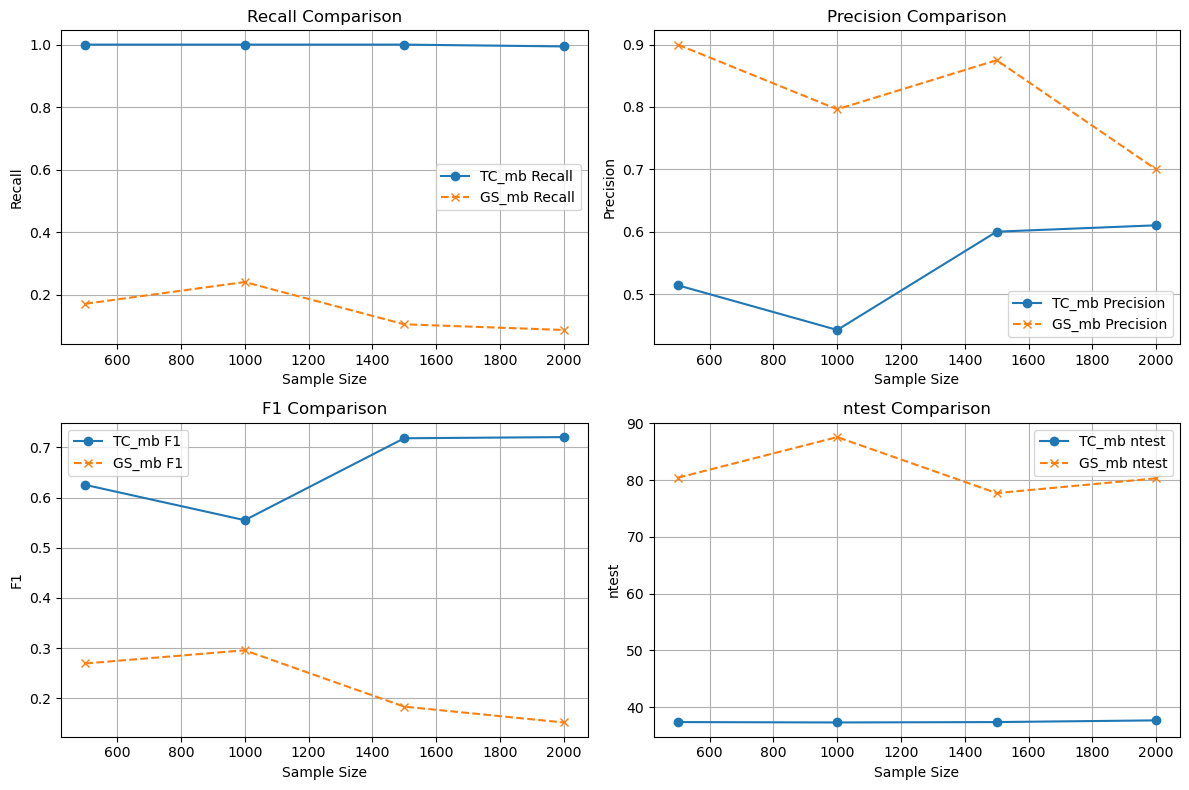

In [7]:
import matplotlib.pyplot as plt

# Extract data for plotting
sample_list = [500, 1000, 1500,2000]
metrics = ['Recall', 'Precision', 'F1', 'ntest']

# Plot each metric for both algorithms
plt.figure(figsize=(12, 8))
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)  # Create a 2x2 grid of subplots
    plt.plot(sample_list, results_tc[metric], marker='o', label=f'TC_mb {metric}')
    plt.plot(sample_list, results_gs[metric], marker='x', linestyle='--', label=f'GS_mb {metric}')
    plt.xlabel('Sample Size')
    plt.ylabel(metric)
    plt.title(f'{metric} Comparison')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()
